## Importing libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample


## Importing Dataset

In [47]:
file_path = 'healthcare-dataset-stroke-data.csv' 
data = pd.read_csv(file_path)

print("Initial Data Head:")
print(data.head())

Initial Data Head:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


## Cleaning Dataset

In [48]:
if 'id' in data.columns:
    data.drop(columns=["id"], inplace=True)
    print("\nDropped 'id' column.")

print("\nMissing values per column:")
print(data.isnull().sum())

if 'bmi' in data.columns:
    data['bmi'] = pd.to_numeric(data['bmi'], errors='coerce') 
    missing_bmi = data['bmi'].isnull().sum()
    if missing_bmi > 0:
        mean_bmi = data['bmi'].mean()
        data['bmi'].fillna(mean_bmi, inplace=True)
        print(f"\nFilled {missing_bmi} missing 'bmi' values with mean: {mean_bmi:.2f}")

print("\nMissing values after 'bmi' imputation:")
print(data.isnull().sum())

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols:
    if col in data.columns:
        missing = data[col].isnull().sum()
        if missing > 0:
            data[col].fillna('Unknown', inplace=True)
            print(f"Filled {missing} missing values in '{col}' with 'Unknown'.")

print("\nData Types Before Encoding:")
print(data.dtypes)


Dropped 'id' column.

Missing values per column:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Filled 201 missing 'bmi' values with mean: 28.89

Missing values after 'bmi' imputation:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Data Types Before Encoding:
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status  

## Splitting Features and Data into test and training sets

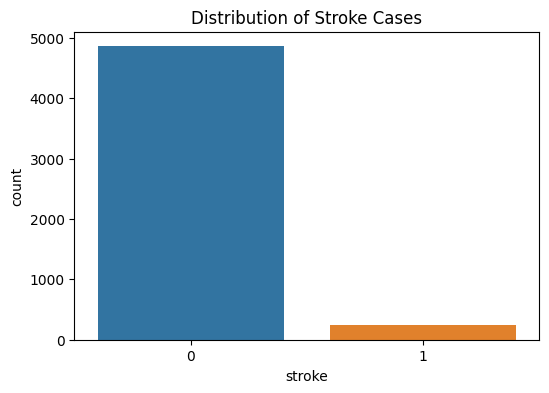


Stroke Class Distribution:
0    4861
1     249
Name: stroke, dtype: int64


In [49]:
plt.figure(figsize=(6,4))
sns.countplot(x='stroke', data=data)
plt.title('Distribution of Stroke Cases')
plt.show()

stroke_counts = data['stroke'].value_counts()
print("\nStroke Class Distribution:")
print(stroke_counts)

X = data.drop(columns=['stroke'])
y = data['stroke']

## Oversampling the Minority Class to Handle Class Imbalance

In [50]:
print("\nBefore Oversampling:")
print(y.value_counts())

majority = X[y == 0]
minority = X[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=majority.shape[0], 
    random_state=42
)

y_minority_upsampled = resample(
    y_minority,
    replace=True,
    n_samples=majority.shape[0],
    random_state=42
)

X_upsampled = pd.concat([majority, minority_upsampled])
y_upsampled = pd.concat([y_majority, y_minority_upsampled])

X_upsampled, y_upsampled = X_upsampled.reset_index(drop=True), y_upsampled.reset_index(drop=True)

print("\nAfter Oversampling:")
print(y_upsampled.value_counts())


Before Oversampling:
0    4861
1     249
Name: stroke, dtype: int64

After Oversampling:
0    4861
1    4861
Name: stroke, dtype: int64


## Splitting into Training and Test Sets

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X_upsampled, y_upsampled,
    test_size=0.2,
    stratify=y_upsampled,
    random_state=42
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (7777, 10)
Test set size: (1945, 10)


## Classifying columns

In [52]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

## Defining Models

In [53]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "SVM": SVC(class_weight='balanced', probability=True)
}

param_grids = {
    "LogisticRegression": {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    "KNN": {
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    },
    "RandomForest": {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5]
    },
    "SVM": {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto'],
        'clf__kernel': ['rbf', 'linear']
    }
}

best_models = []
results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Training Models and Comparing Performances

In [54]:
print("\nStarting model training and parameter tuning...")

for name, model in models.items():
    print(f"\nTuning and training {name}...")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=cv,
        verbose=0,
        n_jobs=-1,
        scoring='f1' 
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    best_models.append((name, best_model))
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    
    results.append((name, acc, prec, rec, f1, roc_auc, avg_prec, training_time))
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} Precision: {prec:.4f}")
    print(f"{name} Recall: {rec:.4f}")
    print(f"{name} F1 Score: {f1:.4f}")
    print(f"{name} ROC-AUC: {roc_auc:.4f}")
    print(f"{name} Average Precision: {avg_prec:.4f}")
    print(f"{name} Training Time: {training_time:.2f} seconds")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

print("\nAll models trained and tuned.")

cols = ["Model", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "Avg_Precision", "Training_Time(s)"]
results_df = pd.DataFrame(results, columns=cols).sort_values(by="F1", ascending=False)
print("\nComparison of Models:")
print(results_df)




Starting model training and parameter tuning...

Tuning and training LogisticRegression...
Best parameters for LogisticRegression: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
LogisticRegression Accuracy: 0.7897
LogisticRegression Precision: 0.7638
LogisticRegression Recall: 0.8385
LogisticRegression F1 Score: 0.7994
LogisticRegression ROC-AUC: 0.8591
LogisticRegression Average Precision: 0.8060
LogisticRegression Training Time: 4.56 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       973
           1       0.76      0.84      0.80       972

    accuracy                           0.79      1945
   macro avg       0.79      0.79      0.79      1945
weighted avg       0.79      0.79      0.79      1945

Confusion Matrix:
[[721 252]
 [157 815]]

Tuning and training KNN...
Best parameters for KNN: {'clf__metric': 'euclidean', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
KNN Accurac

## ROC Curves for all models

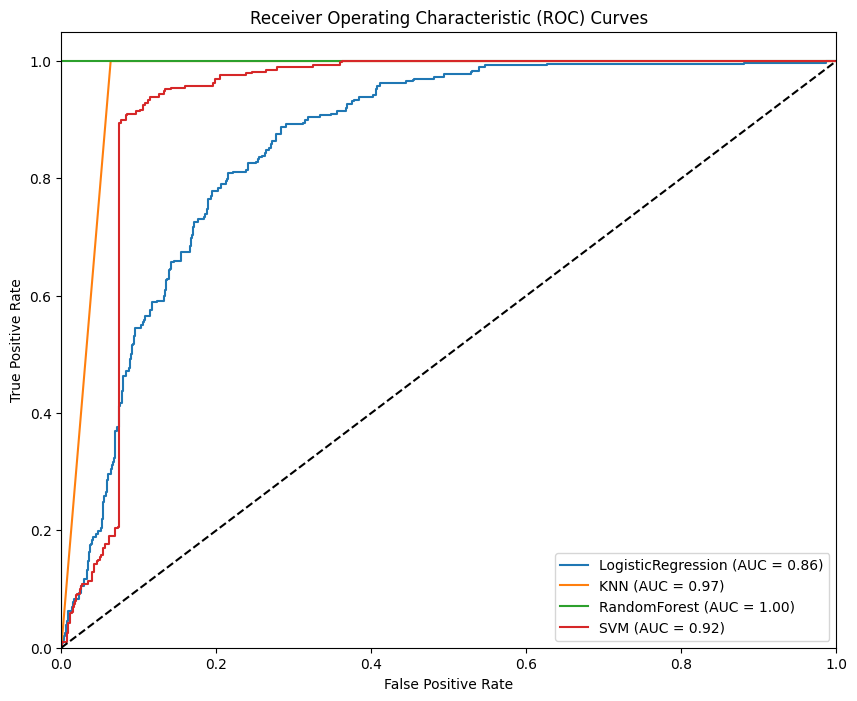

In [55]:
plt.figure(figsize=(10, 8))
for name, model in best_models:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.show()

## Deciding Models and Feature Importances


Feature Importances:
                           Feature  Importance
0                              age    0.394274
1                avg_glucose_level    0.207629
2                              bmi    0.199090
7                 ever_married_Yes    0.024058
6                  ever_married_No    0.020208
17     smoking_status_never smoked    0.017046
11         work_type_Self-employed    0.014117
16  smoking_status_formerly smoked    0.013981
10               work_type_Private    0.013702
3                    gender_Female    0.012897
4                      gender_Male    0.012443
15          smoking_status_Unknown    0.012373
13            Residence_type_Rural    0.012252
14            Residence_type_Urban    0.012188
12              work_type_children    0.011969
18           smoking_status_smokes    0.011338
8               work_type_Govt_job    0.010252
9           work_type_Never_worked    0.000177
5                     gender_Other    0.000005


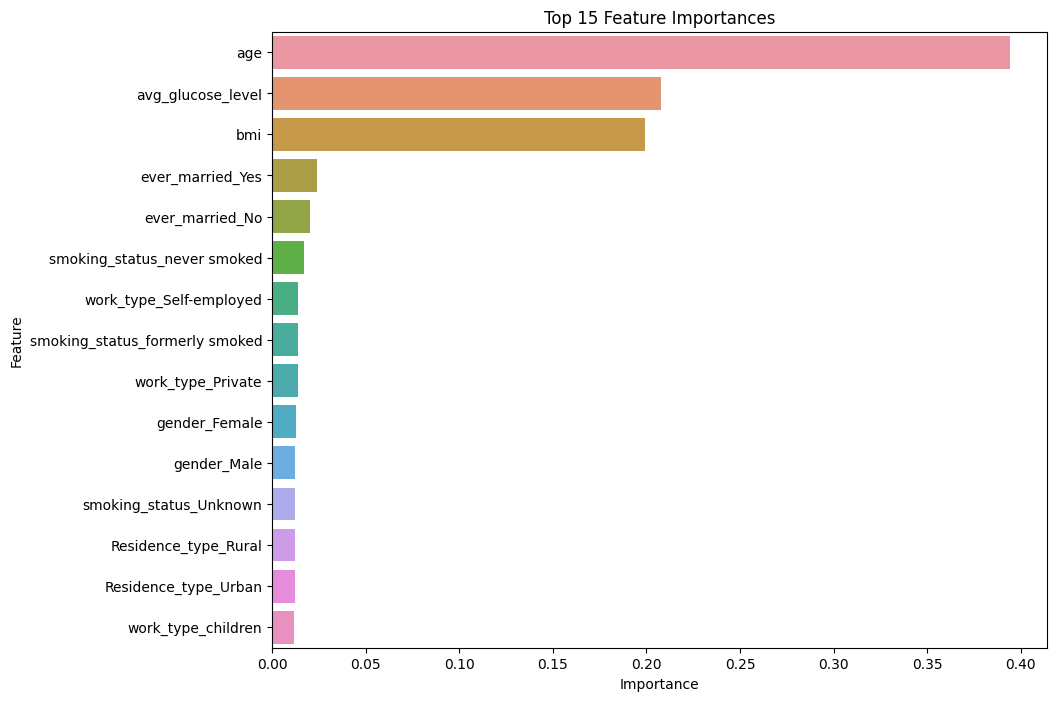

In [58]:
best_model_name = results_df.iloc[0]['Model']
best_model = next((model for name, model in best_models if name == best_model_name), None)

if best_model_name == "RandomForest" and best_model:
    preprocessor_steps = best_model.named_steps['preprocessor']
    ohe = preprocessor_steps.named_transformers_['cat']
    ohe_features = ohe.get_feature_names_out(categorical_cols)
    all_features = numerical_cols + list(ohe_features)
    
    importances = best_model.named_steps['clf'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(feature_importance_df)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title("Top 15 Feature Importances")
    plt.show()
else:
    print(f"\nFeature importance is not available for the best model: {best_model_name}")
